# Multiple Objectives for Residential PV

## Set up.

### Import packages.

In [2]:
import os
import sys
sys.path.insert(0, os.path.abspath(".."))

In [3]:
import numpy             as np
import matplotlib.pyplot as pl
import pandas            as pd
import seaborn           as sb
import tyche             as ty

In [4]:
print(sb.__version__)

0.10.0


In [5]:
arrays = [['Falcon', 'Falcon', 'Parrot', 'Parrot'],
          ['Captive', 'Wild', 'Captive', 'Wild']]
index = pd.MultiIndex.from_arrays(arrays, names=('Animal', 'Type'))
ser = pd.Series([390., 350., 30., 20.], index=index, name="Max Speed")
type(ser)
#ser.groupby(level=0).mean()

pandas.core.series.Series

<AxesSubplot:xlabel='day', ylabel='total_bill'>

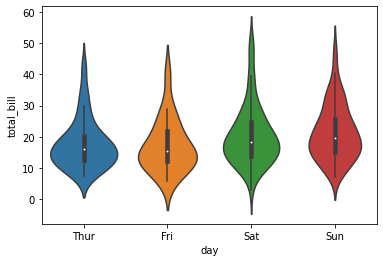

In [6]:
tips = sb.load_dataset("tips")
# sb.boxplot(x='day', y='total_bill', data=tips)
sb.violinplot(data=tips, x="day", y="total_bill")

## Prepare data.

The data are stored in a set of tab-separated value files in a folder. Compile the production and metric functions for each technology in the dataset.

In [7]:
designs = ty.Designs("../../data/residential_pv_multiobjective")
investments = ty.Investments("../../data/residential_pv_multiobjective")
designs.compile()

## Multi-objective decision analysis.

### Compute costs and metrics for tranches.
Tranches are atomic units for building investment portfolios. Evaluate all of the tranches, so we can assemble them into investments (portfolios).

In [8]:
tranche_results = investments.evaluate_tranches(designs, sample_count=50)

### Fit a response surface to the results.
The response surface interpolates between the discrete set of cases provided in the expert elicitation. This allows us to study funding levels intermediate between those scenarios.

In [9]:
evaluator = ty.Evaluator(investments.tranches, tranche_results.summary)
evaluator.max_amount
evaluator.units;

#### Example interpolation.
Let's evaluate the case where each category is invested in at half of its maximum amount.

In [10]:
example_investments = evaluator.max_amount / 2
evaluation = evaluator.evaluate(example_investments)

# Plot

### Functions
- Aggregate over a given index
- Normalize to the maximum sample taken or to the maximum *mean sample*. This will be used to color heat maps

In [11]:
def aggregate_over(ser, idx, statistic = np.mean):
    ser = ser.astype("float64")
    idx_res = list(set(ser.index.names.copy()) - set(idx))
    return ser.groupby(idx_res).aggregate(statistic)

def normalize_to_max_sample(x):
    x_mean = aggregate_over(x, ['Sample'])
    x_max = aggregate_over(abs(x), ['Sample','Category'], np.max)
    return x_mean / x_max

def normalize_to_max_mean(x):
    x_mean = aggregate_over(evaluation, ['Sample'])
    x_max = aggregate_over(abs(x_mean), ['Category'], np.max)
    return x_mean / x_max

In [12]:
def label_metric(evaluator, met):
    return str(met + "\n" + label_units(evaluator,met))
def label_units(evaluator, met):
    return str(evaluator.units.loc[met][0])

### Variables

In [13]:
mets = list(evaluator.metrics);          M = len(mets)
cats = list(example_investments.index);  C = len(cats)

## Heatmap

In [15]:
ser_norm = normalize_to_max_sample(evaluation)
ser_norm = ser_norm.unstack(level = 'Index')

ser_mean = aggregate_over(evaluation, ['Sample'])
ser_mean = ser_mean.unstack(level = 'Index')

ax = sb.heatmap(ser_norm, linewidths=0.5,
    vmax=1.0, vmin=-1.0,
    cmap="coolwarm_r")

ax.xaxis.set_ticks_position('top')
pl.yticks(rotation=0)
pl.ylabel('')
pl.xlabel('');

pl.savefig("assets/heatmap.png")

AttributeError: module 'matplotlib.pyplot' has no attribute 'set_tight_layout'

### Annotated heatmap

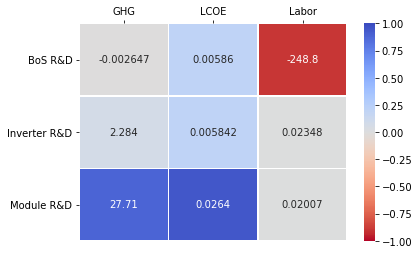

In [352]:
ser_norm = normalize_to_max_sample(evaluation)
ser_norm = ser_norm.unstack(level = 'Index')

ser_mean = aggregate_over(evaluation, ['Sample'])
ser_mean = ser_mean.unstack(level = 'Index')

ax = sb.heatmap(ser_norm, linewidths=0.5,
    annot = ser_mean,
    fmt = '.4g',
    vmax=1.0, vmin=-1.0,
    cmap="coolwarm_r")

ax.xaxis.set_ticks_position('top')
pl.yticks(rotation=0)
pl.ylabel('')
pl.xlabel('');

pl.savefig("assets/heatmap_annotated.png")

## In columns

### Box

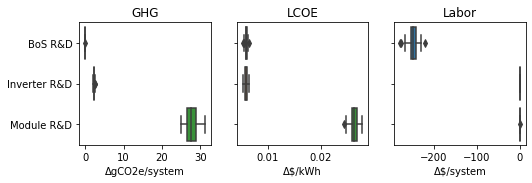

In [354]:
TYPE = "box"
(fig,ax) = pl.subplots(1,M,sharey=True,figsize=(2*(C+1),M*0.75))

for ii in range(M):
    data = evaluation.xs(mets[ii], level = "Index"
        ).astype("float64").reset_index()
    if TYPE == "box":
        sb.boxplot(y = 'Category', x = 'Value', data = data, ax = ax[ii])
    elif TYPE == "violin":
        sb.violinplot(y = 'Category', x = 'Value', data = data, ax = ax[ii])
    ax[ii].set(
        title = mets[ii],
        xlabel = label_units(evaluator, mets[ii]),
        ylabel = "",
    )
fig.savefig("assets/col_" + TYPE + ".png")

In [350]:
# mm=0;cc=0;

# data_metric = evaluation.xs(mets[mm], level = "Index"
#         ).astype("float64")
# data = data_metric.xs(cats[cc], level = "Category").reset_index();
# sb.boxplot(x='Value', data=data)

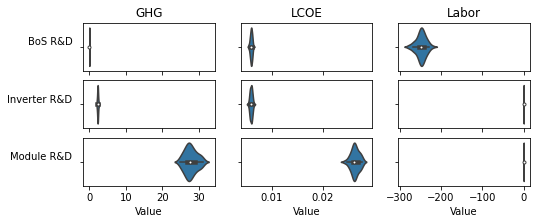

In [359]:
TYPE = "violin"
(fig,ax) = pl.subplots(C,M,sharex='col',figsize=(2*(C+1),M))

for mm in range(M):
    data_metric = evaluation.xs(mets[mm], level = "Index"
        ).astype("float64")


    for cc in range(C):
        data = data_metric.xs(cats[cc], level = "Category").reset_index()
        ax[cc,mm].set(xlabel=label_units(evaluator, mets[mm]))
        ax[cc,mm].set_ylabel(cats[cc],rotation=0,ha='right')

        if TYPE == "box":
            sb.boxplot(x = 'Value', data=data, ax = ax[cc,mm])
        elif TYPE == "violin":
            sb.violinplot(x = 'Value', data = data, ax = ax[cc,mm])
        elif TYPE == "dist":
            sb.distplot(data.drop(['Sample'], axis=1), hist = False, ax = ax[cc,mm])
            ax[cc,mm].set(yticks=[], yticklabels=[])

        ax[cc,mm].label_outer()
    ax[0,mm].set(title=mets[mm])

fig.savefig("assets/grid_" + TYPE + ".png")

,Category,Value
0,BoS R&D,-251.870352
1,BoS R&D,-267.206045
2,BoS R&D,-256.949074
3,BoS R&D,-278.247248
4,BoS R&D,-256.990611
...,...,...
145,Module R&D,0.044379
146,Module R&D,-0.011397
147,Module R&D,0.040328
148,Module R&D,-0.007652


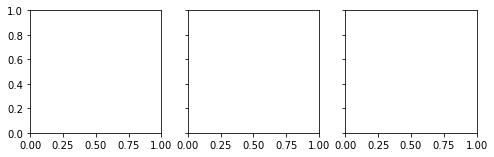

In [294]:
(fig,ax) = pl.subplots(1,M,sharey=True,figsize=(2*(C+1),M*0.75))
for mm in range(M):
    data = evaluation.xs(mets[mm], level = "Index"
        ).astype("float64").reset_index()
    # show(data)
    # sb.distplot(data.drop('Sample', axis=1))
    # ax[mm].set(
    #     title = mets[mm],
    #     xlabel = label_units(evaluator, mets[mm]),
    #     ylabel = "",
    # )
    # ax[mm].xaxis.set_label_position('top')

## Plot Grid

In [ ]:
summary = evaluation.xs("Labor", level = "Index")
values = summary.xs("BoS R&D", level = "Category")

In [ ]:
summary = evaluation.xs("GHG", level = "Index")
values = summary.xs("Module R&D", level = "Category")
# sbplt = sb.boxplot(y = values)
sbplt = sb.boxplot(data = pd.DataFrame(values))

y0 = min(0, evaluator.min_metric.loc["GHG"][0])
y1 = max(0, evaluator.max_metric.loc["GHG"][0])
dy = (y1 - y0) / 20

sbplt.set(
  xlabel = "Module R&D",
  ylabel = "GHG [" + evaluator.units.loc["GHG"].values[0] + "]",
  ylim = (y0 - dy, y1 + dy),
);

# plt.savefig('assets/plots/box/plot.png')

In [ ]:
sb.distplot(values, hist = False)
plt.savefig('assets/plots/dist/plot.png')

In [ ]:
uniform_data = np.random.rand(10, 12)
ax = sb.heatmap(uniform_data)

Let's evaluate the mean instead of outputing the whole distribution.

In [ ]:
example_investments

In [ ]:
evaluator.evaluate_statistic(example_investments, np.mean)

Here is the standard deviation:

In [ ]:
evaluator.evaluate_statistic(example_investments, np.std)

A risk-averse decision maker might be interested in the 10% percentile:

In [ ]:
evaluator.evaluate_statistic(example_investments, lambda x: np.quantile(x, 0.1))

### ε-Constraint multiobjective optimization

In [ ]:
optimizer = ty.EpsilonConstraintOptimizer(evaluator)

In order to meaningfully map the decision space, we need to know the maximum values for each of the metrics.

In [ ]:
metric_max = optimizer.max_metrics()
metric_max

#### Example optimization.

Limit spending to $3M.

In [ ]:
investment_max = 3e6

Require that the GHG reduction be at least 40 gCO2e/system and that the Labor wages not decrease.

In [ ]:
metric_min = pd.Series([40, 0], name = "Value", index = ["GHG", "Labor"])
metric_min

Compute the ε-constrained maximum for the LCOE.

In [ ]:
optimum = optimizer.maximize(
    "LCOE"                       ,
    total_amount = investment_max,
    min_metric   = metric_min    ,
    statistic    = np.mean       ,
)
optimum.exit_message

Here are the optimal spending levels:

In [ ]:
np.round(optimum.amounts)

Here are the three metrics at that optimum:

In [ ]:
optimum.metrics

*Thus, by putting all of the investment into Module R&D, we can expected to achieve a mean 3.75 ¢/kWh reduction in LCOE under the GHG and Labor constraints.*

It turns out that there is no solution for these constraints if we evaluate the 10th percentile of the metrics, for a risk-averse decision maker.

In [ ]:
optimum = optimizer.maximize(
    "LCOE"                       ,
    total_amount = investment_max,
    min_metric   = metric_min    ,
    statistic    = lambda x: np.quantile(x, 0.1),
)
optimum.exit_message

Let's try again, but with a less stringent set of constraints, only constraining GHG somewhat but not Labor at all.

In [ ]:
optimum = optimizer.maximize(
    "LCOE"                                                         ,
    total_amount = investment_max                                  ,
    min_metric   = pd.Series([30], name = "Value", index = ["GHG"]),
    statistic    = lambda x: np.quantile(x, 0.1)                   ,
)
optimum.exit_message

In [ ]:
np.round(optimum.amounts)

In [ ]:
optimum.metrics